# Malaria addInputEIR calibration

### A history matching approach to calibrating an empirical model of malaria infection and immunity
### For iter0 we will cut down parameter space by using the distribution of malaria prevalence by season, age and density bins from a moderate high transmission setting in Sugungum, Garki, Nigeria

# Import block

In [1]:
from IPython.extensions import autoreload
%load_ext autoreload
%autoreload 2
import os, glob, re, sys, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
import itertools
from calibtool.analyzers.Helpers import \
    convert_to_counts, age_from_birth_cohort, season_from_time, aggregate_on_index

# from wand.image import Image as WImage
from IPython.display import IFrame, display

from pyDOE import lhs
from history_matching import HistoryMatching, HistoryMatchingCut, quick_read, Basis
sns.set(font_scale=2)
sns.set_style("white")

Looks like you don't have CUDA, that's okay, we'll try using CPU but it will be SLOW!
Looks like you don't have CUDA, that's okay, we'll try using CPU but it will be SLOW!


In [2]:
def fix_glob(pth):
    return re.sub('([\[\]])','[\\1]', pth)

# Configure parameters and data for history matching

In [3]:
site = 'Sugungum'
season_cut = 'W2'
age_bin_cut = 8
density_bin_cut = 50

cut_name = f'{density_bin_cut}_{age_bin_cut}_{season_cut}_{site}'

# iteration = int(re.search(r'iter(\d+)', os.getcwd())) # Index of the current iteration
iteration = 0 
#list of exp_ids/folders that correspond to exp_ids from which our emulation will draw
exp_ids = ['3d1429d9-3e3d-ea11-a2c3-c4346bcb1551'] # TODO: only uses first for now, should loop
basedir = 'C:\git\Malaria-Uganda-PRISM'
datafile = os.path.join('..','reference data', 'Garki_df.csv')

In [4]:
# The implausibility threshold determines how willing we are to retain regions
# of parameter space that are inconsistent with the underlying data. A higher
# threshold is more risk averse in that potentially good regions are less likely
# to be rejected, however it will take more iterations/simulations to achieve results.
implausibility_threshold = 3
training_fraction = 0.75 # Fraction of simulations to use as training
discrepancy_std = 0.0 # Accounts for uncertainty w.r.t model structure
n_samples_to_generate_for_next_iter = 1000 # Number of simulations to conduct on this iteration

In [5]:
# Here we define the parameter names and ranges
params_file = os.path.join('..','Params.xlsx')
param_info = quick_read(params_file, 'Params').set_index('Name')
param_names = param_info.index.tolist()

params = param_info.index.values
n_params = param_info.shape[0] # We'll use this one place later
display(param_info)

Reading Params from ..\Params_7bac51da3efef654c885a1cf0fac989d.hd5


,Min,Max,MapTo
Name,,,
Biological_Age_Immune_Coefficient_PPP,0.000,20.0,Biological_Age_Immune_Coefficient_PPP
Biological_Age_Immune_Coefficient_TM,0.000,2.0,Biological_Age_Immune_Coefficient_TM
Cumulative_Exposure_Immune_Coefficient_PPP,0.000,20.0,Cumulative_Exposure_Immune_Coefficient_PPP
Cumulative_Exposure_Immune_Coefficient_TM,0.000,2.0,Cumulative_Exposure_Immune_Coefficient_TM
Scale_Factor_Age_a,3.000,5.0,Scale_Factor_Age_a
Scale_Factor_Age_b,0.100,0.3,Scale_Factor_Age_b
Scale_Factor_Cum_Exp_shape,0.100,100.0,Scale_Factor_Cum_Exp_shape
Concurrent_Infections_c,20.000,30.0,Concurrent_Infections_c
Wave_Vs_Infection_Relative_Weight,0.001,100.0,Wave_Vs_Infection_Relative_Weight


## Read in Sim Results

In [6]:
all_samples = []
all_results = []
for exp_id in exp_ids:
    
    print('-'*80, '\nExperiment:', exp_id)
    sim_results_fn = os.path.join(exp_id, 'full_analyzer_results.csv')
    print(sim_results_fn)
    sr = pd.read_csv(sim_results_fn, skipinitialspace=True)
    
    sr = sr[(sr.season == season_cut)&(sr.age_bin ==age_bin_cut)&(sr.density_bin==density_bin_cut)]
    print(sr.head())
    sr['Sample_Id'] = sr['sample'].apply(lambda x: '%s.%06d' % (exp_id, x))
    sr.rename(columns = {'sim_id': 'Sim_Id','value':'Result'}, inplace=True)
    all_results.append( sr )
    #read in tags making a samples.xlsx file 
    s = pd.read_excel(os.path.join(exp_id, 'Samples.xlsx'))
    # s.drop('Sim_Id', axis=1, inplace=True)
    s['Sample_Id'] = s['Sample'].apply(lambda x: '%s.%06d' % (exp_id, x))
    all_samples.append( s )

#.rename(columns={'level_1': 'Year', 0: 'Cases'}) \
all_results = pd.concat(all_results) \
    .set_index(['Sample_Id', 'Sim_Id']) \
    [['Result']] \
    .sort_index()

samples = pd.concat(all_samples).set_index('Sample_Id').sort_index() # Bad because sample will be repeated across exp_id!
                       
samples.to_csv('Samples.csv')
all_results.to_csv('Results.csv')
results = all_results['Result']

results = all_results \
    .groupby(['Sample_Id', 'Sim_Id']) \
    .mean()

    
results.rename(columns={'Result':'Sim_Result'}, inplace=True)
print(type(results))
display(results.head())

-------------------------------------------------------------------------------- 
Experiment: 3d1429d9-3e3d-ea11-a2c3-c4346bcb1551
3d1429d9-3e3d-ea11-a2c3-c4346bcb1551\full_analyzer_results.csv
     Unnamed: 0  sample                                sim_id season  age_bin  \
44            0       1  0d8972df-3e3d-ea11-a2c3-c4346bcb1551     W2        8   
107           0      16  1c8972df-3e3d-ea11-a2c3-c4346bcb1551     W2        8   
170           0       7  138972df-3e3d-ea11-a2c3-c4346bcb1551     W2        8   
233           0      48  2b8972df-3e3d-ea11-a2c3-c4346bcb1551     W2        8   
296           0      20  268972df-3e3d-ea11-a2c3-c4346bcb1551     W2        8   

     density_bin     value  
44            50  0.433014  
107           50  0.176471  
170           50  0.064583  
233           50  0.746269  
296           50  0.212794  
<class 'pandas.core.frame.DataFrame'>


,,Sim_Result
Sample_Id,Sim_Id,
3d1429d9-3e3d-ea11-a2c3-c4346bcb1551.000000,0c8972df-3e3d-ea11-a2c3-c4346bcb1551,0.161111
3d1429d9-3e3d-ea11-a2c3-c4346bcb1551.000001,0d8972df-3e3d-ea11-a2c3-c4346bcb1551,0.433014
3d1429d9-3e3d-ea11-a2c3-c4346bcb1551.000002,0e8972df-3e3d-ea11-a2c3-c4346bcb1551,0.647658
3d1429d9-3e3d-ea11-a2c3-c4346bcb1551.000003,0f8972df-3e3d-ea11-a2c3-c4346bcb1551,0.915663
3d1429d9-3e3d-ea11-a2c3-c4346bcb1551.000004,108972df-3e3d-ea11-a2c3-c4346bcb1551,0.541195


In [7]:
def grouped_df(df, pfprdict, index, column_keep, column_del):
    """
    Recut dataframe to recategorize data into desired age and parasitemia bins

    Args:
        df: Dataframe to be rebinned
        pfprdict: Dictionary mapping postive counts per slide view (http://garkiproject.nd.edu/demographic-parasitological-surveys.html)
                to density of parasites/gametocytes per uL
        index: Multi index into which 'df' is rebinned
        column_keep: Column (e.g. parasitemia) to keep
        column_del: Column (e.g. gametocytemia) to delete
    """
    dftemp = df.copy()
    del dftemp[column_del]

    dftemp['PfPR Bin'] = df[column_keep]
    dftemp = aggregate_on_index(dftemp, index)

    dfGrouped = dftemp.groupby(['Season', 'Age Bin', 'PfPR Bin'])

    dftemp = dfGrouped[column_keep].count()
    dftemp = dftemp.unstack().fillna(0).stack()
    dftemp = dftemp.rename(column_keep).reset_index()
    dftemp['PfPR Bin'] = [pfprdict[p] for p in dftemp['PfPR Bin']]

    dftemp = dftemp.set_index(['Season', 'Age Bin', 'PfPR Bin'])

    return dftemp

In [8]:
ref_data_path = os.path.join('..','reference data','Garki_df.csv')
df = pd.read_csv(ref_data_path)

self = pd.DataFrame()
self.metadata =  {
        'density_bins': [0, 50, 200, 500, np.inf],  # (, 0] (0, 50] ... (50000, ]
        'density_bin_edges':['0', '50', '200', '500'],
        'age_bins': [0, 1, 4, 8, 18, 28, 43, np.inf],  # (, 5] (5, 15] (15, ],
        'age_bin_labels':['<1', '1-4', '4-8', '8-18', '18-28', '28-43', '>43'],
        'seasons': ['DC2', 'DH2', 'W2'],
        'seasons_by_month': {
            'Apr': 'DH2',
            'June/Aug': 'W2',
            'Dec/Jan': 'DC2'
        },
        'village': 'Sugungum'
    }

df = df.loc[df['Village']==self.metadata['village']]
pfprBinsDensity = self.metadata['density_bins']
uL_per_field = 0.5 / 200.0  # from Garki PDF - page 111 - 0.5 uL per 200 views
pfprBins = 1 - np.exp(-np.asarray(pfprBinsDensity) * uL_per_field)
seasons = self.metadata['seasons']
pfprdict = dict(zip(pfprBins, pfprBinsDensity))

bins = OrderedDict([
    ('Season', self.metadata['seasons']),
    ('Age Bin', self.metadata['age_bins']),
    ('PfPR Bin', pfprBins)
])
bin_tuples = list(itertools.product(*bins.values()))
index = pd.MultiIndex.from_tuples(bin_tuples, names=bins.keys())

df = df.loc[df['Seasons'].isin(seasons)]
df = df.rename(columns={'Seasons': 'Season', 'Age': 'Age Bin'})

df2 = grouped_df(df, pfprdict, index, 'Parasitemia', 'Gametocytemia')
df3 = grouped_df(df, pfprdict, index, 'Gametocytemia', 'Parasitemia')
dfJoined = df2.join(df3).fillna(0)
dfJoined = pd.concat([dfJoined['Gametocytemia'], dfJoined['Parasitemia']])
dfJoined.name = 'Counts'
dftemp = dfJoined.reset_index()
dftemp['Channel'] = 'PfPR by Gametocytemia and Age Bin'
dftemp.loc[len(dftemp) / 2:, 'Channel'] = 'PfPR by Parasitemia and Age Bin'
dftemp = dftemp.rename(columns={'Seasons': 'Season', 'PfPR Bins': 'PfPR Bin', 'Age Bins': 'Age Bin'})
dftemp = dftemp.set_index(['Channel', 'Season', 'Age Bin', 'PfPR Bin'])

# how to set the cwd
ref_data =dftemp
ref_data['bin_pop'] = ref_data.groupby(by=['Channel', 'Season', 'Age Bin'])['Counts'].sum()
ref_data['proportion'] = ref_data['Counts'] / ref_data['bin_pop']
ref_data.reset_index(inplace=True)
ref_data = ref_data[ref_data['Channel'] == 'PfPR by Parasitemia and Age Bin']

new_ref_df = pd.DataFrame()
for i, grouping in ref_data.groupby(by=['Channel', 'Season', 'Age Bin']):
    group_subset = pd.DataFrame()
    
    low = grouping[grouping['PfPR Bin'] == 50]
    low.proportion += grouping[grouping['PfPR Bin'] == 0]['proportion'].values[0]
        
    middle = grouping[grouping['PfPR Bin'] == 500]
    middle.proportion += grouping[grouping['PfPR Bin'] == 200]['proportion'].values[0]
    
    high = grouping[grouping['PfPR Bin'] == np.inf]
    new_ref_df = pd.concat([new_ref_df,low,middle,high])
new_ref_df.drop('Counts',axis = 1, inplace=True)    
new_ref_df = new_ref_df[(new_ref_df.Season == season_cut) & (new_ref_df['Age Bin'] == age_bin_cut) & (new_ref_df['PfPR Bin'] == density_bin_cut)]
new_ref_df['binomial error'] = np.sqrt((new_ref_df['proportion']*(1-new_ref_df['proportion']))/new_ref_df['bin_pop'])
print(new_ref_df)
mean = new_ref_df.proportion
error = new_ref_df['binomial error']


desired_result = mean.values[0]
desired_result_std = error.values[0]

print('Before logit, desired result is %.3f [%.3f, %.3f]: ' % (desired_result, desired_result-2*desired_result_std, desired_result+2*desired_result_std))


c:\venv\malaria-ug-icemr\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  app.launch_new_instance()
c:\venv\malaria-ug-icemr\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


                             Channel Season Age Bin  PfPR Bin  bin_pop  \
186  PfPR by Parasitemia and Age Bin     W2     8.0      50.0    162.0   

     proportion  binomial error  
186    0.320988         0.03668  
Before logit, desired result is 0.321 [0.248, 0.394]: 


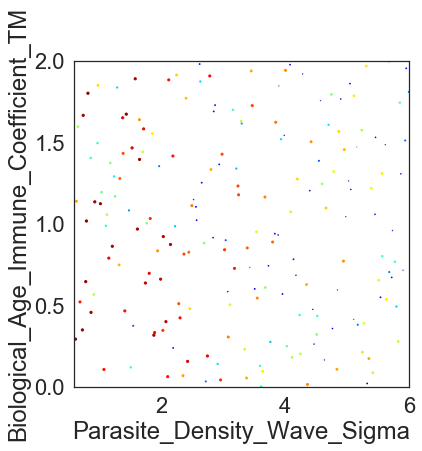

In [9]:
z = pd.merge(samples, results, on='Sample_Id') # Return to Sample_Id

#sub in variables here, can be list of tuples
xyvars = [('Parasite_Density_Wave_Sigma',	'Biological_Age_Immune_Coefficient_TM'
)]
for (xvar, yvar) in xyvars:
    fig = plt.figure(figsize=(6,6))
    plt.scatter(z[xvar], z[yvar], c=100*z['Sim_Result'], s=5*z['Sim_Result'], cmap='jet')
    plt.xlabel(xvar); plt.ylabel(yvar)
    plt.xlim([param_info.loc[xvar, 'Min'], param_info.loc[xvar, 'Max']])
    plt.ylim([param_info.loc[yvar, 'Min'], param_info.loc[yvar, 'Max']])
    # TODO: Show as surface and plot desired result as isocline
plt.show()

In [10]:
# Finally we get to do some History Matching!
# Begin by creating an instance of the HistoryMatching class
print(type(results))
ext = 'svg' # Filetype for figures produced by history matching
hm = HistoryMatching(
    cut_name = cut_name,
    param_info = param_info,
    inputs = samples,
    results = results.squeeze(),
    desired_result = desired_result,
    desired_result_var = desired_result_std**2,
    iteration = iteration,
    implausibility_threshold = implausibility_threshold,
    discrepancy_var = discrepancy_std**2,
    training_fraction = training_fraction,
    fig_type = ext
)
hm.save() # Save to disk

<class 'pandas.core.frame.DataFrame'>
Welcome to IDM History Matching!
Found 200 unique parameter configurations, each of which is repeated 1 time(s).
--> Training with 150 unique parameter configurations ( 150  simulations including replicates)
--> Testing  with 50  unique parameter configurations ( 50 simulations including replicates)


Regularize:  0  of  15
Regularize:  1  of  15
Regularize:  2  of  15
Regularize:  3  of  15
Regularize:  4  of  15
Regularize:  5  of  15
Regularize:  6  of  15
Regularize:  7  of  15
Regularize:  8  of  15
Regularize:  9  of  15
Regularize:  10  of  15
Regularize:  11  of  15
Regularize:  12  of  15
Regularize:  13  of  15
Regularize:  14  of  15


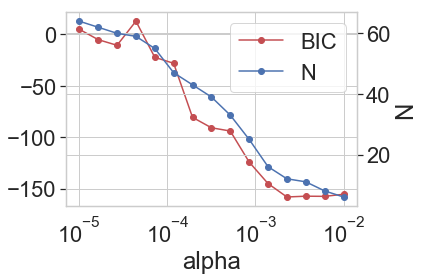

What would you like to use for the GLM regularization parameter, alpha_glm = 2e-3
User selected alpha = 0.002000
Non-Zero: 12 of 66
Regularization for GLM selected:
  * Intercept
 * Biological_Age_Immune_Coefficient_PPP
 * Biological_Age_Immune_Coefficient_TM
 * Cumulative_Exposure_Immune_Coefficient_PPP
 * Parasite_Density_Wave_Sigma
 * Cumulative_Exposure_Immune_Coefficient_TM ** 2
 * Scale_Factor_Age_b ** 2
 * Biological_Age_Immune_Coefficient_TM * Parasite_Density_Wave_Sigma
 * Cumulative_Exposure_Immune_Coefficient_PPP * Cumulative_Exposure_Immune_Coefficient_TM
 * Cumulative_Exposure_Immune_Coefficient_PPP * Scale_Factor_Age_b
 * Scale_Factor_Cum_Exp_shape * Parasite_Density_Wave_Sigma
 * Concurrent_Infections_c * Parasite_Density_Wave_Sigma


In [11]:
try:
    existing_basis = True
    need_basis = True
    with open(os.path.join('Cuts', cut_name, 'basis_glm.json')) as data_file:
        config = json.load( data_file )
        basis_glm = Basis.deserialize(config['Basis'])
        fitted_values = pd.read_json(config['Fitted_Values'], orient='split').set_index(['Sample_Id', 'Sim_Id']).squeeze()
except:
    existing_basis = False
    
if existing_basis:
    print('Found existing GLM basis with the following terms:')
    display(basis_glm.model_terms)
    reply = input('Would you like to use this basis? [Y]/n: ')
    
    if reply.lower() != 'n':
        need_basis = False
    
if need_basis:
    basis_glm = Basis.polynomial_basis(params=param_names, intercept = True, first_order=True, second_order=True, third_order=False, param_info=param_info)

    basis_glm.plot_regularize(samples, results, alpha = np.logspace(-5, -2, 15), scaleX=True)
    alpha_glm = float(input('What would you like to use for the GLM regularization parameter, alpha_glm = '))
#     alpha_glm = 1e-1
    
    fitted_values = basis_glm.regularize(samples, results, alpha = alpha_glm, scaleX=True)
    print('Regularization for GLM selected:\n', ' *','\n * '.join(basis_glm.get_terms()))
    with open(os.path.join('Cuts', cut_name, 'basis_glm.json'), 'w') as fout:
        json.dump( {
            'Basis': basis_glm.serialize(),
            'Fitted_Values': fitted_values.reset_index().to_json(orient='split')
        }, fout, indent=4)

In [12]:
# Now fit the glm and plot

### GLM ###############################################################
print("="*80, "\nGeneralized Linear Modeling\n", "="*80)
#######################################################################
f = hm.glm(
    basis = basis_glm,
    family = 'Poisson',
    force_optimize_glm = True,
    glm_fit_maxiter = 1000,
    plot = True, #force_optimize_glm,
    plot_data = True
)

Generalized Linear Modeling
Plotting


In [13]:
for file in glob.glob(fix_glob(os.path.join(hm.glmdir, "PairwiseResults", "*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

In [14]:
# Results get saved to disk, so load and display:
for file in glob.glob(fix_glob(os.path.join(hm.glmdir, "GLM Predicted vs Actual*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

..\iter0\Cuts\50_8_W2_Sugungum\GLM\GLM Predicted vs Actual.svg


In [15]:
basis_gpr = Basis.polynomial_basis(
    params =  ['Scale_Factor_Age_a', 'Scale_Factor_Age_b','Biological_Age_Immune_Coefficient_PPP',
'Biological_Age_Immune_Coefficient_TM',
'Cumulative_Exposure_Immune_Coefficient_PPP',
'Cumulative_Exposure_Immune_Coefficient_TM'
              ],
#     params = param_info.index.values, #
    intercept = False, 
    first_order = True, 
    param_info=param_info)

In [16]:

### GPR ###############################################################
print("="*80, "\nGaussian Process Regression\n", "="*80)
#######################################################################
hm.gpr(
    basis = basis_gpr,
    force_optimize_gpr = True,

    sigma2_f_guess = 0.6,
    sigma2_f_bounds = (0.1, 1000),
    sigma2_n_guess =  2.0,
    sigma2_n_bounds = (0.01, 100),

    #lengthscale_guess = [0.09844299, 0.1256657, 0.0976875, 0.09889085, 0.1051974, 0.0950809, 0.10032171, 0.10599185, 0.10627393, 0.09950996, 0.09445544, 0.10285915, 0.10007409, 0.09847433, 0.08963389, 0.10205652, 0.09360044, 0.1024141, 0.09786228, 0.10247492, 0.09852253, 0.09632744, 0.09997534, 0.10767302, 0.10095249, 0.09941825, 0.10214923, 0.10221497, 0.09734157, 0.09093285, 0.10780673, 0.09881377, 0.10597152],
    lengthscale_guess = 0.25,
    lengthscale_bounds = (0.01, 100),

    optimize_sigma2_n = True,
    log_transform = False,

    verbose = True,
    optimizer_options = {
        'eps': 5e-3,
        'disp': True,
        'maxiter': 15000,
        'ftol': 2 * np.finfo(float).eps,
        'gtol': 2 * np.finfo(float).eps,
    },
    plot = True, #force_optimize_gpr,
    plot_data = False
)

Gaussian Process Regression
Fitting the GPR

	LL: 231.2212212811234 
	Theta: [0.6  2.   0.25 0.25 0.25 0.25 0.25 0.25] 
	Deriv: [ 3.92186841 20.78304956 -6.0630893  -6.17976904 -4.88730738 -6.74837969
 20.75375306 -4.03374111]

	LL: 3441.6692170988626 
	Theta: [0.1        0.01       6.3130893  6.42976904 5.13730738 6.99837969
 0.01       4.28374111] 
	Deriv: [-1.39890573e+03 -3.41178317e+05 -1.76117479e+00  9.34540431e+00
  8.60533261e+00  4.92521954e+00  9.30616251e+03  1.78872643e+01]

	LL: 201.437376461837 
	Theta: [0.42650523 1.30949083 2.35382853 2.39431518 1.94584451 2.59161712
 0.16672251 1.64966594] 
	Deriv: [-5.16918147 28.81900299 -0.14811014 -0.11811867 -0.08679348 -0.20619748
 40.39868199 -0.17362003]

	LL: 2563.7005174679925 
	Theta: [0.82080812 0.01       3.35087011 3.40779724 2.74680907 3.70480915
 0.01       2.3192723 ] 
	Deriv: [-5.82535106e+02 -2.15480949e+05  1.94328565e+01  3.75453351e+01
  6.98376681e+01  3.47114351e+01  3.95393988e+04  1.71244071e+02]

	LL: 185.97


	LL: 168.6827268168742 
	Theta: [ 0.44266536  0.31166573 11.28490382  5.69781242  0.10821861  9.65787209
  0.02846328  0.06332116] 
	Deriv: [-7.93727891e+00 -5.31194273e+01  1.55653548e-02  1.33237634e-01
 -7.93060781e+00 -2.44139705e-02  2.48410582e+01  4.60181942e+01]

	LL: 171.93629289596433 
	Theta: [5.80961572e-01 4.42590119e-01 1.35604899e+01 6.87392991e+00
 4.21915126e-01 1.16136346e+01 1.00000000e-02 1.00000000e-02] 
	Deriv: [ 3.19575884e+00  2.52854809e+01 -1.82653354e-03 -1.87206188e-02
  6.44485910e+00 -1.32528352e-02 -6.05660979e+02 -1.07313728e+01]

	LL: 166.7023309785594 
	Theta: [ 0.49503493  0.36124376 12.14661541  6.1431808   0.22700819 10.39847391
  0.02147167  0.04312968] 
	Deriv: [-5.11786023e-01 -1.89368852e+01  6.85312372e-03  2.65177673e-02
  3.44989532e+00 -1.05392525e-02 -1.59568731e+02  7.32934273e+00]

	LL: 166.8015753438099 
	Theta: [4.20959774e-01 3.56479587e-01 1.20444761e+01 6.09253171e+00
 1.70463984e-01 1.03116591e+01 3.21403859e-02 1.00000000e-02] 
	D


	LL: 164.17152257464733 
	Theta: [6.08441992e-01 2.84815919e-01 1.02093897e+01 4.84515917e+00
 9.90638613e-02 8.65849430e+00 2.36860698e-02 1.00000000e-02] 
	Deriv: [-6.78792138e-01 -1.03865875e+00  5.97725835e-03  8.18234802e-02
  1.78198516e+00 -5.37331440e-02  4.41206060e+00  4.19302113e+02]

	LL: 164.21389065423506 
	Theta: [0.60709273 0.28223199 7.00358227 3.01363964 0.09587406 5.93276895
 0.02593047 0.01      ] 
	Deriv: [-1.36537901e+00  1.33123205e+00 -3.74376726e-03  1.48934319e-01
  2.87869381e+00 -1.16458502e-01  3.61838286e+01  3.49776529e+02]

	LL: 164.17031592384265 
	Theta: [0.60822271 0.28439597 9.68837443 4.54749634 0.09854545 8.21550305
 0.02405083 0.01      ] 
	Deriv: [-8.08081292e-01 -8.34381327e-01  5.51544874e-03  9.03928452e-02
  1.87912096e+00 -6.00251073e-02  9.99040488e+00  4.09115376e+02]

	LL: 164.1660619164381 
	Theta: [0.60317469 0.28251533 8.18366968 3.69027211 0.0976293  6.93657972
 0.02376699 0.01      ] 
	Deriv: [-9.29865242e-01  1.18776101e-01  4.6186


	LL: 164.09691503078216 
	Theta: [0.62688007 0.2576497  6.39215724 2.40671934 0.08811339 5.51615538
 0.02347187 0.01      ] 
	Deriv: [-8.66191537e-01 -5.46353182e+00  9.56667132e-03  2.34508279e-01
  4.95483495e+00 -1.27111161e-01  4.27168187e+00  5.24997647e+02]

	LL: 164.08756501262275 
	Theta: [0.62622022 0.25139028 5.87947102 2.05331468 0.08639006 5.10739144
 0.02259689 0.01      ] 
	Deriv: [-8.38413165e-01 -6.21113629e+00  1.11747390e-02  2.62534842e-01
  6.42385109e+00 -1.43012309e-01 -7.63979836e+00  5.63820276e+02]

	LL: 164.08298110658765 
	Theta: [0.62710252 0.24726054 5.43530149 1.77186217 0.08470007 4.74166593
 0.02199546 0.01      ] 
	Deriv: [-6.73805173e-01 -5.73787162e+00  1.03310809e-02  2.70200110e-01
  7.24834248e+00 -1.61698605e-01 -1.72382829e+01  5.82714503e+02]

	LL: 164.07707250356106 
	Theta: [0.62744373 0.24701438 5.35736092 1.72078765 0.08434991 4.67817953
 0.02201953 0.01      ] 
	Deriv: [-6.37041580e-01 -5.37018910e+00  8.98729231e-03  2.68065580e-01
  7.24


	LL: 163.12919073524336 
	Theta: [7.31019988e-01 2.45431035e-01 2.66315102e+01 1.13311250e+00
 7.40694703e-02 2.86517361e+01 2.89566996e-02 1.00000000e-02] 
	Deriv: [ 9.93131304e-01 -4.63003839e-01 -1.21093483e-03  1.99713129e-01
 -3.96336001e+00 -5.39265810e-03  7.48564445e+00  4.56152280e+02]

	LL: 163.08949411404046 
	Theta: [7.28359662e-01 2.47027060e-01 3.21722488e+01 1.12736133e+00
 7.48806780e-02 3.48290448e+01 2.90211629e-02 1.00000000e-02] 
	Deriv: [ 9.25507824e-01 -1.51592457e-01 -8.64283807e-04  1.82795231e-01
 -3.20040704e+00 -3.65634225e-03  6.46738573e+00  4.46122811e+02]

	LL: 163.01992090245017 
	Theta: [7.11249897e-01 2.50168734e-01 4.47306772e+01 1.07244050e+00
 7.62238716e-02 4.88499346e+01 2.85081339e-02 1.00000000e-02] 
	Deriv: [ 7.05396660e-01  8.54374622e-01 -4.81788876e-04  8.93937883e-02
 -1.16250347e+00 -1.81618621e-03  1.34849022e+00  4.28615467e+02]

	LL: 162.98225880208025 
	Theta: [6.88342371e-01 2.51667738e-01 5.78998375e+01 1.00995095e+00
 7.63255553e-0


	LL: 162.94953134014182 
	Theta: [6.85834612e-01 2.49388000e-01 1.00000000e+02 9.84972408e-01
 7.58358222e-02 1.00000000e+02 2.79838217e-02 1.00000000e-02] 
	Deriv: [ 4.23480253e-02 -5.38767461e-02 -9.56570131e-05 -6.96733673e-03
  2.36903839e-01 -4.14127678e-04  3.92185592e-01  4.25157576e+02]

	LL: 162.9494850313775 
	Theta: [6.84902987e-01 2.49358286e-01 1.00000000e+02 9.86092444e-01
 7.57949640e-02 1.00000000e+02 2.79600623e-02 1.00000000e-02] 
	Deriv: [ 1.16770057e-02 -1.10939159e-01 -9.47289581e-05 -1.67464922e-03
  2.09052984e-01 -4.13681723e-04  4.27246654e-01  4.25443478e+02]

	LL: 162.94944843347318 
	Theta: [6.84097808e-01 2.49379920e-01 1.00000000e+02 9.86666223e-01
 7.56729896e-02 1.00000000e+02 2.79103045e-02 1.00000000e-02] 
	Deriv: [ 4.53485298e-04 -8.01016908e-02 -9.36383220e-05  2.18454198e-03
  5.27988559e-02 -4.13107350e-04  8.99180789e-02  4.25512056e+02]

	LL: 162.9494470065245 
	Theta: [6.83330894e-01 2.49608058e-01 1.00000000e+02 9.86381241e-01
 7.56952054e-02 


	LL: 162.9494384427244 
	Theta: [6.83743954e-01 2.49509564e-01 1.00000000e+02 9.86051208e-01
 7.56564431e-02 1.00000000e+02 2.78999379e-02 1.00000000e-02] 
	Deriv: [-5.76166431e-04 -3.05739906e-03 -9.38816818e-05  8.15437515e-05
  4.08833139e-04 -4.13004821e-04  8.85470427e-03  4.24538490e+02]

	LL: 162.9494384427244 
	Theta: [6.83743954e-01 2.49509564e-01 1.00000000e+02 9.86051208e-01
 7.56564431e-02 1.00000000e+02 2.78999379e-02 1.00000000e-02] 
	Deriv: [-5.76166431e-04 -3.05739906e-03 -9.38816818e-05  8.15437515e-05
  4.08833139e-04 -4.13004821e-04  8.85470427e-03  4.24538490e+02]

	LL: 162.94943962998434 
	Theta: [6.83743978e-01 2.49509694e-01 1.00000000e+02 9.86051205e-01
 7.56564255e-02 1.00000000e+02 2.78995636e-02 1.00000000e-02] 
	Deriv: [-4.46305236e-04 -2.80699564e-03 -9.38759993e-05  7.86782859e-05
  4.59113335e-04 -4.13002078e-04  4.08066631e-03  4.24545065e+02]

	LL: 162.94943773390756 
	Theta: [6.83743954e-01 2.49509565e-01 1.00000000e+02 9.86051208e-01
 7.56564431e-02 


	LL: 162.94943766696966 
	Theta: [6.83743954e-01 2.49509565e-01 1.00000000e+02 9.86051208e-01
 7.56564431e-02 1.00000000e+02 2.78999375e-02 1.00000000e-02] 
	Deriv: [-5.80989384e-04 -3.05376372e-03 -9.38817107e-05  8.11215639e-05
  4.00031556e-04 -4.13004838e-04  8.85604409e-03  4.24538480e+02]

	LL: 162.94943751060586 
	Theta: [6.83743954e-01 2.49509565e-01 1.00000000e+02 9.86051208e-01
 7.56564431e-02 1.00000000e+02 2.78999376e-02 1.00000000e-02] 
	Deriv: [-5.79851528e-04 -3.05270056e-03 -9.38817189e-05  8.09830501e-05
  4.01952876e-04 -4.13004820e-04  8.86124327e-03  4.24538457e+02]

	LL: 162.94943751060586 
	Theta: [6.83743954e-01 2.49509565e-01 1.00000000e+02 9.86051208e-01
 7.56564431e-02 1.00000000e+02 2.78999376e-02 1.00000000e-02] 
	Deriv: [-5.79851528e-04 -3.05270056e-03 -9.38817189e-05  8.09830501e-05
  4.01952876e-04 -4.13004820e-04  8.86124327e-03  4.24538457e+02]

	LL: 162.94943768012072 
	Theta: [6.83743954e-01 2.49509565e-01 1.00000000e+02 9.86051208e-01
 7.56564431e-0


	LL: 162.94943749114566 
	Theta: [6.83743954e-01 2.49509565e-01 1.00000000e+02 9.86051208e-01
 7.56564431e-02 1.00000000e+02 2.78999374e-02 1.00000000e-02] 
	Deriv: [-5.79293711e-04 -3.05203656e-03 -9.38816847e-05  8.09783908e-05
  4.05699892e-04 -4.13004878e-04  8.83192661e-03  4.24538455e+02]

	LL: 162.94943749114566 
	Theta: [6.83743954e-01 2.49509565e-01 1.00000000e+02 9.86051208e-01
 7.56564431e-02 1.00000000e+02 2.78999374e-02 1.00000000e-02] 
	Deriv: [-5.79293711e-04 -3.05203656e-03 -9.38816847e-05  8.09783908e-05
  4.05699892e-04 -4.13004878e-04  8.83192661e-03  4.24538455e+02]

	LL: 162.94943749114566 
	Theta: [6.83743954e-01 2.49509565e-01 1.00000000e+02 9.86051208e-01
 7.56564431e-02 1.00000000e+02 2.78999374e-02 1.00000000e-02] 
	Deriv: [-5.79293619e-04 -3.05203656e-03 -9.38816847e-05  8.09783908e-05
  4.05699892e-04 -4.13004878e-04  8.83192661e-03  4.24538455e+02]

	LL: 162.9494375270997 
	Theta: [6.83743954e-01 2.49509565e-01 1.00000000e+02 9.86051208e-01
 7.56564431e-02


	LL: 162.94943749109993 
	Theta: [6.83743954e-01 2.49509565e-01 1.00000000e+02 9.86051208e-01
 7.56564431e-02 1.00000000e+02 2.78999374e-02 1.00000000e-02] 
	Deriv: [-5.79298285e-04 -3.05203654e-03 -9.38816847e-05  8.09784384e-05
  4.05685928e-04 -4.13004878e-04  8.83192031e-03  4.24538456e+02]

	LL: 162.94943749109993 
	Theta: [6.83743954e-01 2.49509565e-01 1.00000000e+02 9.86051208e-01
 7.56564431e-02 1.00000000e+02 2.78999374e-02 1.00000000e-02] 
	Deriv: [-5.79298285e-04 -3.05203654e-03 -9.38816847e-05  8.09784384e-05
  4.05685928e-04 -4.13004878e-04  8.83192031e-03  4.24538456e+02]

	LL: 162.94943757173104 
	Theta: [6.83743954e-01 2.49509565e-01 1.00000000e+02 9.86051208e-01
 7.56564431e-02 1.00000000e+02 2.78999374e-02 1.00000000e-02] 
	Deriv: [-5.79870127e-04 -3.05247461e-03 -9.38816827e-05  8.09899651e-05
  4.06521620e-04 -4.13004875e-04  8.83750626e-03  4.24538452e+02]

	LL: 163.5668730497329 
	Theta: [6.84323252e-01 2.52561601e-01 1.00000000e+02 9.85970230e-01
 7.52507572e-02

In [17]:
pi = param_info.loc[basis_gpr.param_dict.keys()].reset_index()
pi['Lengthscale'] = hm.gpr_model.theta[2:]
print(pi[['Name', 'Lengthscale']].sort_values('Lengthscale'))

                                         Name  Lengthscale
5   Cumulative_Exposure_Immune_Coefficient_TM     0.010000
4  Cumulative_Exposure_Immune_Coefficient_PPP     0.027900
2       Biological_Age_Immune_Coefficient_PPP     0.075656
1                          Scale_Factor_Age_b     0.986051
0                          Scale_Factor_Age_a   100.000000
3        Biological_Age_Immune_Coefficient_TM   100.000000


In [18]:
# Results get saved to disk, so load and display:
for file in glob.glob(fix_glob(os.path.join(hm.gprdir, "PairwiseResults", "*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

In [19]:
### Implausibility ############################################################
print("="*80, "\nImplausibility\n", "="*80)
###############################################################################
hm.calc_and_plot_implausibility(
    plot = True,
    do_plot_data = False,
    plot_data_highlight = pd.DataFrame() #hm.test_data.loc['prime.000049']
) 
    #plot_data_highlight=pd.DataFrame() # plot_data_highlight=hm.training_data.loc['prime.000049']

hm.training_data.to_excel(os.path.join('Cuts', cut_name, 'train_data.xlsx'))
hm.test_data.to_excel(os.path.join('Cuts', cut_name, 'test_data.xlsx'))

print('Good')

Implausibility
Good


In [20]:
# Results get saved to disk, so load and display:
for file in glob.glob(fix_glob(os.path.join(hm.combineddir, "*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

..\iter0\Cuts\50_8_W2_Sugungum\Implausibility\implausibility.svg


In [21]:
ar = all_results.reset_index()

data = ar.loc[ar['AgeBin']==age_bin[0]].groupby(['Sample_Id','AgeBin'])['Result'].mean().reset_index().set_index('Sample_Id')

train = hm.training_data
train['Train'] = True
test = hm.test_data
test['Train'] = False
train_test = pd.concat([train, test])

fig, ax = plt.subplots(figsize=(16,10))

# Reference
#ref_by_year = reference_data[['Prevalence']].reset_index()

ref_by_year = ref_df.loc[ref_df['Age bin'] == int(age_bin[0][:2])] \
    .groupby('Age bin') \
    .mean() \
    .reset_index()
print(ref_by_year)
print(data)
sns.lineplot(data=ref_by_year, x='Age bin', y='Mean', color='k', marker='o', alpha=1, lw=2, zorder=1);

# Sims
tmp = data.merge(train_test[['Sample_Orig', 'Implausible', 'Train']], left_on='Sample_Id', right_on='Sample_Orig')
print(tmp.head())
sns.lineplot(data=tmp, x='AgeBin', y='Result', hue='Implausible', style='Train', 
             units='Sample_Orig', estimator=None, alpha=0.5, lw=0.5,
             ax=ax, zorder=-1)
ax.set_xlabel('AgeBin');
ax.set_ylabel('Duration');
ax.set_xticks(ref_by_year['Age bin'].unique());

KeyError: 'AgeBin'